In [24]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, AvgPool2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import preprocessing
from keras.preprocessing import image
import keras
import cv2
import tqdm
import pickle
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
SENTENCE_LENGTH = 1 #length of the longest sentence possible. shorter ones are padded with zeros.
NUM_DIFF_WORDS = 2 #number of different words that need to be encoded, i.e. size of vocabulary.
SKIP_FRAMES = 5 #set >1 to skip frames when filling volume with previous frames.
MEMORY = 10 #third dimension of input volume, defines how much history is available for the network.
IMGW = 128 #image width.
IMGH = 128 #image height.

In [ ]:
#to load synthetic data, follow this structure...
#dataset_file = 'cap2vid/dataset/gifcap_icons_1elems_periods[8,12]_caplen18.h5'
# with h5py.File(dataset_file, 'r') as hf:
#     imgs = np.float32(np.array(hf.get('gifs')))
#     captions = np.float32(np.array(hf.get('captions')))
# print(set(list(captions.flatten())))
# print(imgs.shape)
# print(captions.shape)

In [ ]:
#read human motion data.
f = open('cap2vid/dataset/pickle_x_1.pkl', 'rb')
X1 = pickle.load(f)
f.close()
f = open('cap2vid/dataset/pickle_x_2.pkl', 'rb')
X2 = pickle.load(f)
f.close()
f = open('cap2vid/dataset/pickle_x_3.pkl', 'rb')
X3 = pickle.load(f)
f.close()
f = open('cap2vid/dataset/pickle_x_4.pkl', 'rb')
X4 = pickle.load(f)
f.close()

In [15]:
X = []
X.extend(X1)
X.extend(X2)
X.extend(X3)
X.extend(X4)
len(X)

400

In [16]:
for i in range(len(X)):
    X[i] = np.array(X[i], dtype=np.float32)[:,:,:,0]

In [19]:
#optionally skip some frames.
Xnew = []
for i in range(len(X)):
    Xnew.append(X[i][0:X[i].shape[0]:SKIP_FRAMES, :, :])
    
print(X[0].shape)
print(Xnew[0].shape)
X = Xnew

(75, 120, 160)
(15, 120, 160)


In [20]:
#optionally resize.
X2 = []
for i in tqdm(range(len(X))):
    arr = np.zeros(shape=(X[i].shape[0], IMGW,IMGH), dtype=np.float32)
    for j in range(X[i].shape[0]):
        arr[j] = cv2.resize(X[i][j], (IMGW,IMGH))
    X2.append(arr)
del X
imgs = X2

100%|██████████| 400/400 [00:04<00:00, 80.76it/s]


(15, 128, 128)


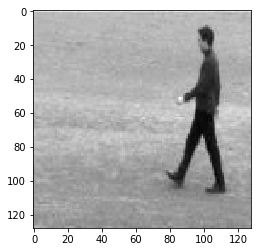

In [23]:
print(imgs[0].shape)
res = plt.imshow(imgs[0][4,:,:],cmap='gray')

In [22]:
#read sentences.
f = open('cap2vid/dataset/pickle_y.pkl', 'rb')
Y = pickle.load(f)
f.close()
Y = np.array(Y, dtype=np.float32)
Y = Y.reshape(-1,1)
print(Y.shape)
captions = Y
print(Y.dtype)

(400, 1)
float32


In [15]:
def encode_caption_in_image_onehot(caption, width=0, height=0, resize=True):
    res_matrix = np.zeros(shape=(SENTENCE_LENGTH,NUM_DIFF_WORDS))
    for windex in range(len(caption)):
        vec = one_hot(caption[windex])
        res_matrix[windex] = vec
    if resize:
        res_matrix = cv2.resize(res_matrix, (width,height), interpolation=cv2.INTER_NEAREST)
    return res_matrix

def one_hot(val):
    val = int(val)
    vec = np.zeros(NUM_DIFF_WORDS)
    vec[val] = 1
    return vec

In [16]:
#use word-based one-hot encoding for sentence representation.
#for complex sentences, computing a proper sentence embedding, e.g. with an LSTM, is recommended.
imgs_captions_small = []
for i in range(captions.shape[0]):
    imgs_captions_small.append(encode_caption_in_image_onehot(captions[i], resize=False).flatten())
    
imgs_captions_small = np.array(imgs_captions_small)

In [19]:
num_examples = 120 #limit number of examples being pre-processed. set according to memory limitations.

X_img_in = []
X_captions_in = []
Y_img_out = []

for i in tqdm(range(num_examples)): 
    this_sequence = imgs[i] #example i here is of shape (numframes,w,h)
    for num_previous_included in range(1, this_sequence.shape[0]):
        X_this = np.zeros(shape=(IMGW,IMGH,MEMORY))
        prev_frames = this_sequence[max(0,num_previous_included-MEMORY):num_previous_included] 
        prev_frames = np.swapaxes(prev_frames, 0, 1)
        prev_frames = np.swapaxes(prev_frames, 1, 2)
        X_this[:,:,0:num_previous_included] = prev_frames
        next_frame = this_sequence[num_previous_included]
        
        X_img_in.append(X_this.copy())
        X_captions_in.append(imgs_captions_small[i])
        Y_img_out.append(next_frame.reshape(IMGW,IMGH,1))

X_img_in = np.array(X_img_in, dtype=np.float32)
X_captions_in = np.array(X_captions_in, dtype=np.float32)
Y_img_out = np.array(Y_img_out, dtype=np.float32)
print(X_img_in.shape)
print(X_captions_in.shape)
print(Y_img_out.shape)

100%|██████████| 120/120 [00:02<00:00, 45.59it/s]


(2336, 128, 128, 10)
(2336, 2)
(2336, 128, 128, 1)


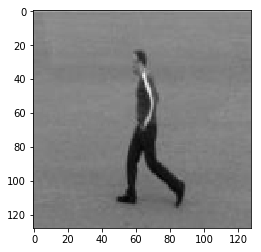

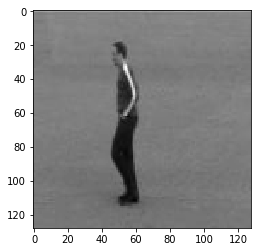

In [21]:
plt.imshow(X_img_in[320,:,:,7], cmap='gray')
plt.figure()
plt.imshow(Y_img_out[320,:,:,0], cmap='gray')

In [22]:
X_img_in/=255.0 #normalize images
Y_img_out/=255.0

(0.0, 1.0)
(0.0, 1.0)
(0.017386641, 1.0)


In [23]:
def get_unet(width, height, lrate=1e-4, start_filters=8, dr_rate=0):
    inputs = Input((height, width, MEMORY)) #image volume input
  
    conv1 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = AvgPool2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = AvgPool2D(pool_size=(2, 2))(conv2)
  
    conv3 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = AvgPool2D(pool_size=(2, 2))(conv3)
  
    conv4 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(dr_rate)(conv4) 
    pool4 = AvgPool2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(start_filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(start_filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(dr_rate)(conv5)

    
    
    flat = keras.layers.Flatten()(conv4)
    inputs_hidden = Input((NUM_DIFF_WORDS*SENTENCE_LENGTH,), name='hidden_input') #sentence representation input
    hiddenmerge = merge([flat,inputs_hidden], mode = 'concat', concat_axis = 1, name='hidden_merge')
    dense1 = keras.layers.Dense(1024, activation='relu', name='dense1')(hiddenmerge)
    dense2 = keras.layers.Dense(8192, activation='relu', name='dense2')(dense1)
    rshp = keras.layers.Reshape(target_shape=(8,8,128))(dense2)
 

    
    up6 = Conv2D(start_filters*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(rshp))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
      
    up7 = Conv2D(start_filters*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(start_filters*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(start_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(input = [inputs, inputs_hidden], output = conv10)

    #for fully binary images, binary_crossentropy is a good choice.
    model.compile(optimizer = Adam(lr = lrate), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    return model

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 10) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  728         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
print(X_img_in.min(), X_img_in.max())
print(X_captions_in.min(), X_captions_in.max())
print(Y_img_out.min(), Y_img_out.max())

print(X_img_in.shape)
print(X_captions_in.shape)
print(Y_img_out.shape)

In [29]:
model = get_unet(IMGW, IMGH, lrate=0.0001, start_filters=8, dr_rate=0.5)

In [88]:
#optionally, load existing model
#model = keras.models.load_model('weights.100.hdf5')

#optionally, save current model.
#model.save('model-walk2-reg-05.hdf5')

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator()
datagen_val = keras.preprocessing.image.ImageDataGenerator()
batchsize = 4 #batch size, set according to memory limitations.
train_epochs = 1000 #number of epochs
val_estimate = 10 #to estimate validation accuracy, val_estimate*batchsize many examples will be considered.
iter_per_epoch = 1000 #number of iterations per epoch, i.e. batchsize*iter_per_epoch many examples are considered each epoch.

checkpointer = ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5', verbose=1, save_best_only=False, period=50)

#consider using a fit generator if training on very large datasets.
model.fit(x=[X_img_in, X_captions_in], y=Y_img_out, batch_size=batchsize, epochs=500, callbacks=[checkpointer])

In [ ]:
def get_feature_maps(model, layer_in, layer_out, input_image):
    model_ = Model(inputs=[model.layers[layer_in].input], outputs=[model.layers[layer_out].output])
    return model_.predict(input_image)

In [78]:
def predict(img_input, sentence_input, img_groundtruth, recursion=1, flip=False):
    print('caption: ', sentence_input)
    
    if flip:
        sentence_input = np.flip(sentence_input, 0)
    print('new caption: ', sentence_input)
    plt.figure()
    plt.title('input frame (previous)')
    plt.imshow(img_input, cmap='gray')
    
    sentence_input = sentence_input.reshape(1,NUM_DIFF_WORDS*SENTENCE_LENGTH)
    current_img_input = img_input.reshape(1,IMGW,IMGH,1).copy()
    
    X_this = np.zeros(shape=(1,IMGW,IMGH,length_sequences))
    insertion = 0
    plt.figure(figsize=(15,15))
    for i in range(recursion):
        print(current_img_input.shape)
        insertion=i
        if i>=length_sequences:
            X_this = np.roll(X_this, -1, axis=3)
            
        X_this[0,:,:,insertion] = current_img_input.reshape(IMGW,IMGH)
        current_img_input = model.predict(x=[X_this, sentence_input])
        plt.subplot(4,5,i+1)
   
        plt.title('prediction ' + str(i+1))
        plt.imshow(current_img_input[0,:,:,0], cmap='gray')
       

    if not img_groundtruth is None:
        plt.figure()
        plt.title('groundtruth')
        plt.imshow(img_groundtruth[:,:,0], cmap='gray')

('caption: ', array([ 0.,  1.], dtype=float32))
('new caption: ', array([ 0.,  1.], dtype=float32))
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)


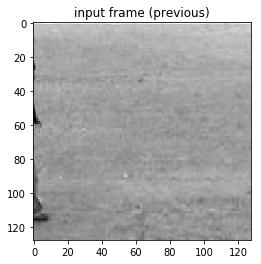

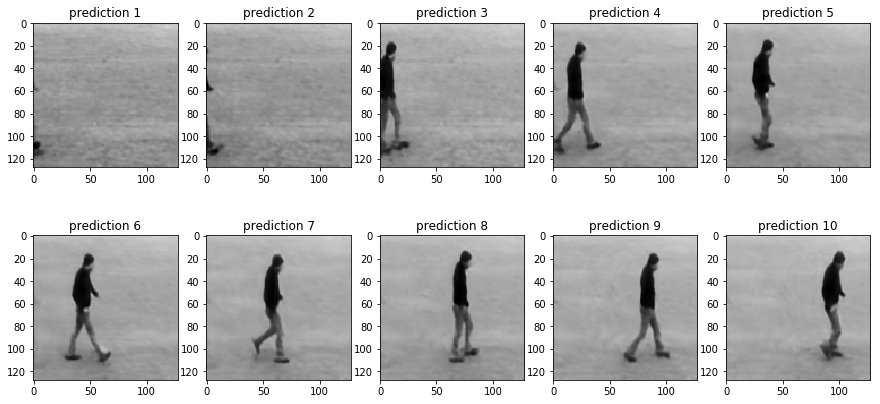

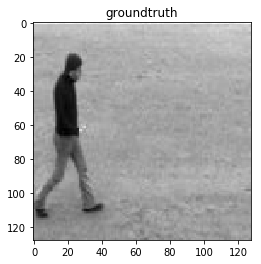

In [60]:
predict(X_img_in[100,:,:,2], X_captions_in[100], Y_img_out[100], recursion=10)

('caption: ', array([ 0.,  1.], dtype=float32))
('new caption: ', array([ 0.,  1.], dtype=float32))
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)


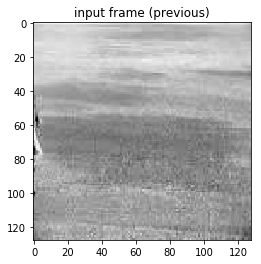

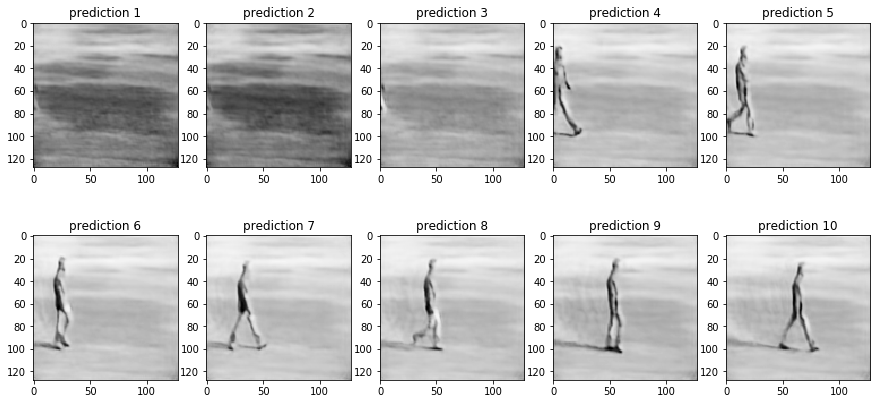

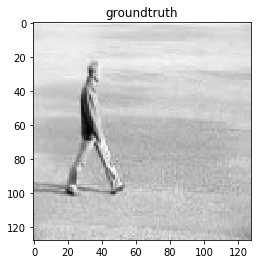

In [77]:
predict(X_img_in[1050,:,:,3], X_captions_in[1050], Y_img_out[1050], recursion=10, flip=False)

[ 1.  0.]
('caption: ', array([ 1.,  0.]))
('new caption: ', array([ 1.,  0.]))
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)


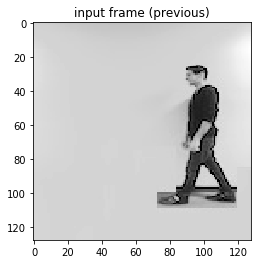

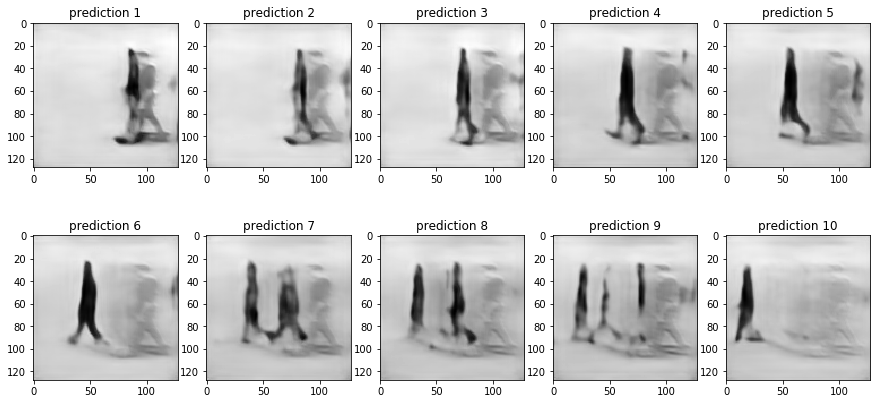

In [89]:
go_left=True

cap = np.zeros(shape=2, dtype=float)
if go_left:
    cap[0] = 1.0
else:
    cap[1] = 1.0
print(cap)
cam = cv2.imread('IMG_3199.jpg', 0)/255.
predict(cam, cap, None, recursion=10, flip=False)